In [1]:
LANGSMITH_TRACING = True
LANGSMITH_ENDPOINT = "https://api.smith.langchain.com"
LANGSMITH_API_KEY = "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"

In [2]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [7]:
from langchain_ollama import ChatOllama

model = ChatOllama(
    model="llama3.2",
    temperature=0.,
    # other params...
)

In [8]:
from langchain_core.messages import HumanMessage

model.invoke([HumanMessage(content="Hi! I'm Bob")])

AIMessage(content="Hello Bob! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-02-07T11:28:21.7308708Z', 'done': True, 'done_reason': 'stop', 'total_duration': 609602500, 'load_duration': 14803300, 'prompt_eval_count': 30, 'prompt_eval_duration': 2000000, 'eval_count': 27, 'eval_duration': 591000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-9044cfb8-d776-432c-b9c5-a421a7867cfd-0', usage_metadata={'input_tokens': 30, 'output_tokens': 27, 'total_tokens': 57})

In [9]:
from langchain_core.messages import AIMessage

model.invoke(
    [
        HumanMessage(content="Hi! I'm Bob"),
        AIMessage(content="Hello Bob! How can I assist you today?"),
        HumanMessage(content="What's my name?"),
    ]
)

AIMessage(content="Your name is Bob. We just established that earlier. Is there something specific you'd like to talk about or ask, Bob?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-02-07T11:29:17.2254346Z', 'done': True, 'done_reason': 'stop', 'total_duration': 588951200, 'load_duration': 15042400, 'prompt_eval_count': 55, 'prompt_eval_duration': 8000000, 'eval_count': 27, 'eval_duration': 261000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-91e81e27-9ca7-4099-ab5f-ac216d7edfef-0', usage_metadata={'input_tokens': 55, 'output_tokens': 27, 'total_tokens': 82})

### Add Langgraph for remembering chat history

In [10]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

workflow = StateGraph(state_schema=MessagesState)

def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)


In [11]:
config = {"configurable": {"thread_id": "abc123"}}

In [12]:
query = "Hi! I'm Dohwi"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello Dohwi! It's nice to meet you. Is there something I can help you with, or would you like to chat?


In [13]:
query = "What's my name?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Dohwi. You mentioned it earlier when we started chatting.


In [14]:
config = {"configurable": {"thread_id": "abc234"}}

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

I don't have any information about your identity, so I'm not aware of your name. This is the start of our conversation, and I'd be happy to chat with you, but I won't be able to recall or access any personal details about you. How can I help you today?


### Prompt template

In [15]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You talk like a pirate. Answer all questions to the best of your ability.",
        ),
        MessagesPlaceholder(variable_name="messages")
    ]
)


In [16]:
workflow = StateGraph(state_schema=MessagesState)

def call_model(state: MessagesState):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": response}

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [17]:
config = {"configurable": {"thread_id": "abc345"}}
query = "Hi! I'm Jim."

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Yer lookin' fer a chat, eh? Well, matey Jim, welcome aboard! I be happy to have ye as me guest. What be bringin' ye to these fair waters today? Got any questions or just want to spin some yarns with ol' Blackbeak Betty?


In [18]:
query = "What is my name?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Arrr, ye be askin' about yer own name, eh? Yer name be Jim, matey! I remember now. Ye told me that when we set sail fer this here conversation. So, Jim, what be on yer mind? Want to talk about the seven seas or maybe find treasure?


In [19]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer all questions to the best of your ability in {language}.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [20]:
from typing import Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict


class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str

workflow = StateGraph(state_schema=State)

def call_model(state: State):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": [response]}

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [22]:
config = {"configurable": {"thread_id": "abc456"}}
query = "Hi! I'm Bob."
language = "Korean"

input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

안녕하세요, 보브! (Annyeonghaseyo, Bob!) 또 만난다! (Toot man nan-da!)


In [23]:
query = "What is my name?"

input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

보브 (Bob)입니다. (Bob-i yeo-hwa-ham-nida.)


### Managing chat history

In [39]:
from langchain_core.messages import SystemMessage, trim_messages

trimmer = trim_messages(
    max_tokens=60,
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)


messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]

trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content="hi! I'm bob", additional_kwargs={}, response_metadata={}),
 AIMessage(content='hi!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='I like vanilla ice cream', additional_kwargs={}, response_metadata={}),
 AIMessage(content='nice', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]

In [40]:
workflow = StateGraph(state_schema=State)


def call_model(state: State):
    trimmed_messages = trimmer.invoke(state["messages"])
    prompt = prompt_template.invoke(
        {"messages": trimmed_messages, "language": state["language"]}
    )
    response = model.invoke(prompt)
    return {"messages": [response]}

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [41]:
config = {"configurable": {"thread_id": "abc567"}}
query = "What is my name?"
language = "English"

input_messages = messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

I don't have any information about your name. We just started our conversation, and I don't retain any data from previous conversations or keep track of individual users. Each time you interact with me, it's a new conversation. Would you like to share your name with me?


In [43]:
config = {"configurable": {"thread_id": "abc678"}}
query = "What math problem did I ask?"
language = "English"

input_messages = messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

You asked me "whats 2 + 2".


In [45]:
config = {"configurable": {"thread_id": "abc789"}}
query = "Hi I'm Todd, please tell me a joke."
language = "English"

input_messages = [HumanMessage(query)]
for chunk, metadata in app.stream(
    {"messages": input_messages, "language": language},
    config,
    stream_mode="messages",
):
    if isinstance(chunk, AIMessage):  # Filter to just model responses
        print(chunk.content, end="")

Hi Todd! Here's one for you:

What do you call a fake noodle?

(wait for it...)

An impasta!

Hope that made you smile! Do you want to hear another one?

In [69]:
SYSTEM_PROMPT = '''
You are a highly capable AI assistant trained to help users in a wide range of tasks, including but not limited to text summarization, explanation of concepts, code generation, and data analysis. 
Your responses should be clear, concise, and formatted appropriately for the task at hand. Always follow these guidelines:

1. **General Tasks**: If the user is asking for information, provide factual, concise answers, avoiding unnecessary elaboration.
2. **Text Summarization**: If the user asks for summarization, condense the key points without losing important information. Use bullet points or short paragraphs.
3. **Code Generation**: When writing code, provide clean, well-commented, and functional code snippets in the language requested. If unsure, ask for clarification.
4. **Concept Explanation**: When explaining concepts, adjust the depth of explanation based on the user's background. Use simple language for beginners and technical details for advanced users.
5. **Structured Data**: For requests involving structured data, respond using JSON or a similar format to avoid ambiguity. Ensure correct field names and data types.
6. **Error Handling**: If you do not know the answer, respond with "I do not know" or suggest a strategy to find the answer.
7. **Safety**: Do not generate harmful, biased, or sensitive content.

If the task requires a specific response format (e.g., JSON, code, table), adhere to the format. When in doubt, ask the user for clarification.
'''
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            SYSTEM_PROMPT,
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
workflow = StateGraph(state_schema=MessagesState)

trimmer = trim_messages(
    max_tokens=6000,
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)

def call_model(state: MessagesState):
    trimmed_messages = trimmer.invoke(state["messages"])
    prompt = prompt_template.invoke(trimmed_messages)
    response = model.invoke(prompt)
    return {"messages": [response]}

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [70]:
config = {"configurable": {"thread_id": "abc8910"}}
query = "Hi I'm Todd, please tell me a joke."
language = "English"

input_messages = [HumanMessage(query)]
for chunk, metadata in app.stream(
    {"messages": input_messages},
    config,
    stream_mode="messages",
):
    if isinstance(chunk, AIMessage):  # Filter to just model responses
        print(chunk.content, end="")

[HumanMessage(content="Hi I'm Todd, please tell me a joke.", additional_kwargs={}, response_metadata={}, id='c6bdeadd-1004-4bb7-a1d1-dab2968c73a1')]
Hello Todd! Here's one:

What do you call a fake noodle?

(wait for it...)

An impasta!

Hope that made you smile! Do you want to hear another one?

In [66]:
trimmer.invoke([
    SystemMessage(content=SYSTEM_PROMPT),
    HumanMessage(content=query)
])

[SystemMessage(content='\nYou are a highly capable AI assistant trained to help users in a wide range of tasks, including but not limited to text summarization, explanation of concepts, code generation, and data analysis. \nYour responses should be clear, concise, and formatted appropriately for the task at hand. Always follow these guidelines:\n\n1. **General Tasks**: If the user is asking for information, provide factual, concise answers, avoiding unnecessary elaboration.\n2. **Text Summarization**: If the user asks for summarization, condense the key points without losing important information. Use bullet points or short paragraphs.\n3. **Code Generation**: When writing code, provide clean, well-commented, and functional code snippets in the language requested. If unsure, ask for clarification.\n4. **Concept Explanation**: When explaining concepts, adjust the depth of explanation based on the user\'s background. Use simple language for beginners and technical details for advanced us

In [121]:

MAX_TOKENS_TRIM = 600

SYSTEM_PROMPT = '''
You are a highly capable AI assistant trained to help users in a wide range of tasks, including but not limited to text summarization, explanation of concepts, code generation, and data analysis. 
Your responses should be clear, concise, and formatted appropriately for the task at hand. Always follow these guidelines:

1. **General Tasks**: If the user is asking for information, provide factual, concise answers, avoiding unnecessary elaboration.
2. **Text Summarization**: If the user asks for summarization, condense the key points without losing important information. Use bullet points or short paragraphs.
3. **Code Generation**: When writing code, provide clean, well-commented, and functional code snippets in the language requested. If unsure, ask for clarification.
4. **Concept Explanation**: When explaining concepts, adjust the depth of explanation based on the user's background. Use simple language for beginners and technical details for advanced users.
5. **Structured Data**: For requests involving structured data, respond using JSON or a similar format to avoid ambiguity. Ensure correct field names and data types.
6. **Error Handling**: If you do not know the answer, respond with "I do not know" or suggest a strategy to find the answer.
7. **Safety**: Do not generate harmful, biased, or sensitive content.

If the task requires a specific response format (e.g., JSON, code, table), adhere to the format. When in doubt, ask the user for clarification.
'''

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str

class LangChainBot():
    pass

model = ChatOllama(
    model="llama3.2",
    temperature=0.,
    # other params...
)


trimmer = trim_messages(
    max_tokens=MAX_TOKENS_TRIM,
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            SYSTEM_PROMPT,
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

workflow = StateGraph(state_schema=MessagesState)


async def call_model(state: MessagesState):
    trimmed_messages = await trimmer.ainvoke(state["messages"])
    prompt = await prompt_template.ainvoke(trimmed_messages)
    response = await model.ainvoke(prompt)
    return {"messages": [response]}

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
# app = workflow.compile(checkpointer=memory)
app = workflow.compile()

config = {"configurable": {"thread_id": "abc8911"}}
query = "Tell me about semiconductor lithography."
language = "English"

input_messages = [HumanMessage(query)]
async for chunk, metadata in app.astream(
    {"messages": input_messages},
    # config,
    stream_mode="messages",
):
    if isinstance(chunk, AIMessage):  # Filter to just model responses
        print(chunk.content, end="|", flush=True)

**Semiconductor Lithography Overview**

Semiconductor lithography is a critical process in the fabrication of microelectronic devices, such as integrated circuits (ICs) and semiconductors. It involves the transfer of patterns onto a photosensitive material, called a resist, to create the desired structure on a semiconductor wafer.

**Key Steps:**

1. **Mask Creation**: A patterned mask is created using electron beam lithography or other techniques.
2. **Wafer Preparation**: The semiconductor wafer is cleaned and prepared for exposure.
3. **Exposure**: The wafer is exposed to light through the mask, creating a pattern on the resist.
4. **Development**: The resist is developed, revealing the underlying semiconductor material.
5. **Etching**: The unwanted material is removed using etching processes.

**Types of Lithography:**

1. **Optical Lithography**: Uses visible light to create patterns on the wafer.
2. **Extreme Ultraviolet (EUV) Lithography**: Uses EUV light with shorter wavelength

In [102]:
chunks = []
async for chunk, metadata in app.astream({"messages": "what color is the sky?"}, config, stream_mode="messages"):
    chunks.append(chunk)
    print(chunk.content, end="|", flush=True)

Blue|

In [132]:
from typing import TypedDict
from langgraph.graph import START, StateGraph, MessagesState


# Note: we're adding the tags here to be able to filter the model outputs down the line
joke_model = ChatOllama(model="llama3.2")
poem_model = ChatOllama(model="llama3.2")


class State(TypedDict):
    topic: str
    joke: str
    poem: str


async def call_model(state, config):
    topic = state["messages"]
    print("Writing joke...")
    # Note: Passing the config through explicitly is required for python < 3.11
    # Since context var support wasn't added before then: https://docs.python.org/3/library/asyncio-task.html#creating-tasks
    joke_response = await joke_model.ainvoke(
        [{"role": "user", "content": f"Write a joke about {topic}"}],
        config,
    )
    return {"joke": joke_response.content}


# graph = StateGraph(MessagesState).add_node(call_model).add_edge(START, "call_model").compile()
graph = StateGraph(MessagesState).add_edge(START, "call_model").add_node(call_model).compile()

async for msg, metadata in graph.astream(
    {"messages": "cats"},
    stream_mode="messages",
):
    if msg.content:
        print(msg.content, end="|", flush=True)

Writing joke...
{'configurable': {'__pregel_resuming': False, '__pregel_task_id': '638c82c3-4c7f-c981-3bf3-c1343ab4982a', '__pregel_send': functools.partial(<function PregelRunner.atick.<locals>.writer at 0x000002A787B93010>, PregelExecutableTask(name='call_model', input={'messages': [HumanMessage(content='cats', additional_kwargs={}, response_metadata={}, id='16338e5e-77a5-45a9-b397-f091982db303')]}, proc=<langgraph.utils.runnable.RunnableSeq object at 0x000002A787BCAFB0>, writes=deque([]), config={'configurable': {'__pregel_resuming': False, '__pregel_task_id': '638c82c3-4c7f-c981-3bf3-c1343ab4982a', '__pregel_send': functools.partial(<function local_write at 0x000002A78E6EFA30>, <built-in method extend of collections.deque object at 0x000002A787B3E1A0>, dict_keys(['__start__', 'call_model'])), '__pregel_read': functools.partial(<function local_read at 0x000002A78E6EF9A0>, 1, {'v': 1, 'ts': '2025-02-07T15:41:19.012518+00:00', 'id': '1efe569f-9632-627c-8000-f1cdf7eec3bc', 'channel_val

In [136]:

MAX_TOKENS_TRIM = 600

SYSTEM_PROMPT = '''
You are a highly capable AI assistant trained to help users in a wide range of tasks, including but not limited to text summarization, explanation of concepts, code generation, and data analysis. 
Your responses should be clear, concise, and formatted appropriately for the task at hand. Always follow these guidelines:

1. **General Tasks**: If the user is asking for information, provide factual, concise answers, avoiding unnecessary elaboration.
2. **Text Summarization**: If the user asks for summarization, condense the key points without losing important information. Use bullet points or short paragraphs.
3. **Code Generation**: When writing code, provide clean, well-commented, and functional code snippets in the language requested. If unsure, ask for clarification.
4. **Concept Explanation**: When explaining concepts, adjust the depth of explanation based on the user's background. Use simple language for beginners and technical details for advanced users.
5. **Structured Data**: For requests involving structured data, respond using JSON or a similar format to avoid ambiguity. Ensure correct field names and data types.
6. **Error Handling**: If you do not know the answer, respond with "I do not know" or suggest a strategy to find the answer.
7. **Safety**: Do not generate harmful, biased, or sensitive content.

If the task requires a specific response format (e.g., JSON, code, table), adhere to the format. When in doubt, ask the user for clarification.
'''

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str

class LangChainBot():
    pass

model = ChatOllama(
    model="llama3.2",
    temperature=0.,
    # other params...
)


trimmer = trim_messages(
    max_tokens=MAX_TOKENS_TRIM,
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            SYSTEM_PROMPT,
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

workflow = StateGraph(state_schema=MessagesState)


async def call_model(state: MessagesState, config):
    trimmed_messages = await trimmer.ainvoke(state["messages"])
    prompt = await prompt_template.ainvoke(trimmed_messages)
    response = await model.ainvoke(prompt, config)
    return {"messages": [response]}

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
# app = workflow.compile(checkpointer=memory)
app = workflow.compile()

config = {"configurable": {"thread_id": "abc8911"}}
query = "Tell me about semiconductor lithography."
language = "English"

input_messages = [HumanMessage(query)]
async for chunk, metadata in app.astream(
    {"messages": input_messages},
    # config,
    stream_mode="messages",
):
    if isinstance(chunk, AIMessage):  # Filter to just model responses
        print(chunk.content, end="|", flush=True)

**|Sem|iconductor| Lith|ography| Overview|**

|Sem|iconductor| lith|ography| is| a| critical| process| in| the| fabrication| of| micro|elect|ronic| devices|,| such| as| integrated| circuits| (|IC|s|)| and| sem|icon|duct|ors|.| It| involves| the| transfer| of| patterns| onto| a| photos|ensitive| material|,| called| a| resist|,| to| create| the| desired| structure| on| a| semiconductor| wa|fer|.

|**|Key| Steps|:|**

|1|.| **|Mask| Creation|**:| A| pattern|ed| mask| is| created| using| electron| beam| lith|ography| or| other| techniques|.
|2|.| **|Wa|fer| Preparation|**:| The| semiconductor| wa|fer| is| cleaned| and| prepared| for| exposure|.
|3|.| **|Ex|posure|**:| The| wa|fer| is| exposed| to| light| through| the| mask|,| creating| a| pattern| on| the| resist|.
|4|.| **|Development|**:| The| resist| is| developed|,| revealing| the| underlying| semiconductor| material|.
|5|.| **|Et|ching|**:| The| unwanted| material| is| removed| using| et|ching| processes|.

|**|Types| of| Lith|ography

### RAG part 1

In [1]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = "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"

In [17]:
from langchain_ollama import ChatOllama
from langchain_ollama import OllamaEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
llm = ChatOllama(
    model="llama3.2",
    temperature=0.,
    # other params...
)
# embeddings = OllamaEmbeddings(model="llama3")
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
# embeddings = HuggingFaceEmbeddings(model_name="allenai/specter")
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
# embeddings = HuggingFaceEmbeddings(model_name="allenai/scibert_scivocab_uncased")

import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [4]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
docs[0].page_content

USER_AGENT environment variable not set, consider setting it to identify your requests.


'\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nS

In [5]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)
len(all_splits)
all_splits[1].page_content

'Memory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model to learn.\nLong-term memory: This provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.\n\n\nTool use\n\nThe agent learns to call external APIs for extra information that is missing from the model weights (often hard to change after pre-training), including current information, code execution capability, access to proprietary information sources and more.'

In [18]:
_ = vector_store.add_documents(documents=all_splits)

In [7]:
# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [8]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [9]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"], k=4)
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [19]:
retrieved_docs = vector_store.similarity_search("What is Task Decomposition?")
retrieved_docs

[Document(id='d25ef0dd-9619-4192-a24f-6b75c0c7dac4', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'),
 Document(id='7abb4a0c-89ec-464c-9275-117da67568b4', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at ea

In [22]:
retrieved_docs[1].page_content

'Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'

In [25]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

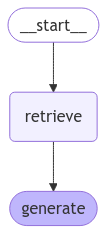

In [24]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='684807d4-75c4-4bb4-85c0-a8524e49e88e', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='14885a91-676b-4d9b-8d72-46a34e240094', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibiliti

In [27]:
from langchain_community.document_loaders import PyPDFLoader

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
# embeddings = HuggingFaceEmbeddings(model_name="allenai/scibert_scivocab_uncased")
# vector_store = InMemoryVectorStore(embeddings)

index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

file_path = "E:\\PythonProjects\\DashTest\\aims.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

print(len(docs))

10


In [28]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)
len(all_splits)
# all_splits[1].page_content

47

In [29]:
_ = vector_store.add_documents(documents=all_splits)

In [35]:
retrieved_docs = vector_store.similarity_search("Tell me about AIMS EUV")
retrieved_docs

[Document(id='0a650b02-7a93-493e-8e9b-1e0304948b25', metadata={'producer': 'PDFlib+PDI 9.0.2 (.NET/Win64)', 'creator': 'PdfCompressor 5.0.595', 'creationdate': '2019-12-11T05:45:09-08:00', 'source': 'E:\\PythonProjects\\DashTest\\aims.pdf', 'total_pages': 10, 'page': 3, 'page_label': '4'}, page_content='3. STATUS UPDATE FROM THE PRODUCTION PIPELINE \nThe AIMSTM EUV first batch of tools built consist of a prototype system and three customer tools. As it was reported \nearly 2018, the AIMS TM EUV prototype tool achieved the last milestone of the development project in Decemb er \n2017 and it now serves the purposes  of EMI members access demonstration, platform software and hardware \ndevelopment, training for customer operators and ZEISS service personnel, as well as the development of new a erial \nimaged based applications.  To describe the tool availability during the afore mentioned EMI access campaigns, the \ngraph in Figure 4 shows the recorded productive time for each measurement

In [32]:
result = graph.invoke({"question": "Tell me about AIMS EUV"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='0a650b02-7a93-493e-8e9b-1e0304948b25', metadata={'producer': 'PDFlib+PDI 9.0.2 (.NET/Win64)', 'creator': 'PdfCompressor 5.0.595', 'creationdate': '2019-12-11T05:45:09-08:00', 'source': 'E:\\PythonProjects\\DashTest\\aims.pdf', 'total_pages': 10, 'page': 3, 'page_label': '4'}, page_content='3. STATUS UPDATE FROM THE PRODUCTION PIPELINE \nThe AIMSTM EUV first batch of tools built consist of a prototype system and three customer tools. As it was reported \nearly 2018, the AIMS TM EUV prototype tool achieved the last milestone of the development project in Decemb er \n2017 and it now serves the purposes  of EMI members access demonstration, platform software and hardware \ndevelopment, training for customer operators and ZEISS service personnel, as well as the development of new a erial \nimaged based applications.  To describe the tool availability during the afore mentioned EMI access campaigns, the \ngraph in Figure 4 shows the recorded productive time for each me

In [36]:
for step in graph.stream(
    {"question": "Tell me about AIMS EUV"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='0a650b02-7a93-493e-8e9b-1e0304948b25', metadata={'producer': 'PDFlib+PDI 9.0.2 (.NET/Win64)', 'creator': 'PdfCompressor 5.0.595', 'creationdate': '2019-12-11T05:45:09-08:00', 'source': 'E:\\PythonProjects\\DashTest\\aims.pdf', 'total_pages': 10, 'page': 3, 'page_label': '4'}, page_content='3. STATUS UPDATE FROM THE PRODUCTION PIPELINE \nThe AIMSTM EUV first batch of tools built consist of a prototype system and three customer tools. As it was reported \nearly 2018, the AIMS TM EUV prototype tool achieved the last milestone of the development project in Decemb er \n2017 and it now serves the purposes  of EMI members access demonstration, platform software and hardware \ndevelopment, training for customer operators and ZEISS service personnel, as well as the development of new a erial \nimaged based applications.  To describe the tool availability during the afore mentioned EMI access campaigns, the \ngraph in Figure 4 shows the recorded productive 

#### Query analysis

In [43]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'producer': 'PDFlib+PDI 9.0.2 (.NET/Win64)',
 'creator': 'PdfCompressor 5.0.595',
 'creationdate': '2019-12-11T05:45:09-08:00',
 'source': 'E:\\PythonProjects\\DashTest\\aims.pdf',
 'total_pages': 10,
 'page': 0,
 'page_label': '1',
 'section': 'beginning'}

In [54]:
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(documents=all_splits)

In [55]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [56]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    print(query)
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [57]:
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

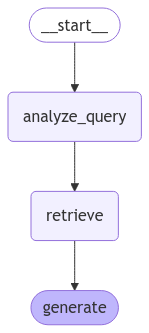

In [58]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
graph.invoke({"question": "What does the end say about Task Decomposition?"})

{'query': 'Task Decomposition', 'section': 'end'}


{'question': 'What does the end say about Task Decomposition?',
 'query': {'query': 'Task Decomposition', 'section': 'end'},
 'context': [Document(id='c8e01988-f70f-4f0e-8906-2764cdb3845d', metadata={'producer': 'PDFlib+PDI 9.0.2 (.NET/Win64)', 'creator': 'PdfCompressor 5.0.595', 'creationdate': '2019-12-11T05:45:09-08:00', 'source': 'E:\\PythonProjects\\DashTest\\aims.pdf', 'total_pages': 10, 'page': 6, 'page_label': '7', 'section': 'end'}, page_content='imaging process. The strong dependencies on several process parameters will have to be taken into account by mask \narchitects in order to be biased and/or corrected for already on the mask. In order to deliver the perfect mask for EUV \nProc. of SPIE Vol. 10810  108100V-6\nDownloaded From: https://www.spiedigitallibrary.org/conference-proceedings-of-spie on 11 Dec 2019\nTerms of Use: https://www.spiedigitallibrary.org/terms-of-use'),
  Document(id='04c8c931-fca5-405b-a3cc-bf3def7a9778', metadata={'producer': 'PDFlib+PDI 9.0.2 (.NET/W

### RAG part 2

In [5]:
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
llm = ChatOllama(
    # model="llama3.2",
    model="mistral-nemo",
    temperature=0.8,
    # other params...
)
# embeddings = OllamaEmbeddings(model="llama3")
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
# embeddings = HuggingFaceEmbeddings(model_name="allenai/specter")
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
# embeddings = HuggingFaceEmbeddings(model_name="allenai/scibert_scivocab_uncased")

vector_store = InMemoryVectorStore(embeddings)

e:\PythonProjects\DashTest\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

_ = vector_store.add_documents(documents=all_splits)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [7]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [8]:
from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


In [9]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    print(f"Query or respond response: {response}")
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [10]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

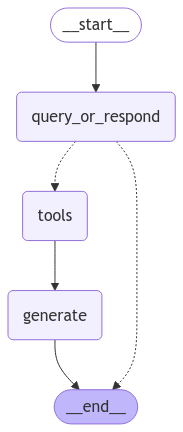

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
input_message = "Tell me about AIMS EUV"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config={"callbacks": [langfuse_handler]}
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Tell me about AIMS EUV
Query or respond response: content='' additional_kwargs={} response_metadata={'model': 'mistral-nemo', 'created_at': '2025-02-11T06:24:24.6903547Z', 'done': True, 'done_reason': 'stop', 'total_duration': 867568400, 'load_duration': 15747600, 'prompt_eval_count': 61, 'prompt_eval_duration': 193000000, 'eval_count': 23, 'eval_duration': 650000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)} id='run-17902e16-1113-485e-b547-7bd2ac34a468-0' tool_calls=[{'name': 'retrieve', 'args': {'query': 'AIMS EUV'}, 'id': '63d7904a-72e4-4917-a1af-d434ac95565f', 'type': 'tool_call'}] usage_metadata={'input_tokens': 61, 'output_tokens': 23, 'total_tokens': 84}
================================== Ai Message ==================================
Tool Calls:
  retrieve (63d7904a-72e4-4917-a1af-d434ac95565f)
 Call ID: 63d7904a-72e4-4917-a1af-d434ac95565f
  Args:
    query: A

### Persistance study

In [1]:
from langfuse import Langfuse
from langfuse.callback import CallbackHandler

langfuse_handler = CallbackHandler(
  secret_key="sk-lf-00e471ca-2111-4262-a488-8f601f293c6b",
  public_key="pk-lf-3898b1bf-11d3-4ef9-8dee-4d9ca2367b50",
  host="http://localhost:3000"
)

In [4]:
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
llm = ChatOllama(
    # model="llama3.2",
    model="mistral-nemo",
    temperature=0.8,
    # other params...
)
llm2 = ChatOllama(
    model="llama3.2",
    # model="mistral-nemo",
    temperature=0.8,
    # other params...
)
# embeddings = OllamaEmbeddings(model="llama3")
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
# embeddings = HuggingFaceEmbeddings(model_name="allenai/specter")
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
# embeddings = HuggingFaceEmbeddings(model_name="allenai/scibert_scivocab_uncased")

vector_store = InMemoryVectorStore(embeddings)

In [3]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated
from typing_extensions import TypedDict
from operator import add

class State(TypedDict):
    foo: int
    bar: Annotated[list[str], add]

def node_a(state: State):
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State):
    return {"foo": "b", "bar": ["b"]}


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "1"}}
graph.invoke({"foo": ""}, config)

{'foo': 'b', 'bar': ['a', 'b']}

In [49]:
graph.get_state(config)

StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe839e-1324-6e9c-8002-d13ddfcb9080'}}, metadata={'source': 'loop', 'writes': {'node_b': {'foo': 'b', 'bar': ['b']}}, 'thread_id': '1', 'step': 2, 'parents': {}}, created_at='2025-02-11T05:34:36.072514+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe839e-1322-6777-8001-dd403d87a56d'}}, tasks=())

In [52]:
new_config = {"configurable": {"thread_id": "1", "checkpoint_id": "1efe839e-1324-6e9c-8002-d13ddfcb9080"}}
graph.get_state(new_config)

StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1efe839e-1324-6e9c-8002-d13ddfcb9080'}}, metadata={'source': 'loop', 'writes': {'node_b': {'foo': 'b', 'bar': ['b']}}, 'thread_id': '1', 'step': 2, 'parents': {}}, created_at='2025-02-11T05:34:36.072514+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe839e-1322-6777-8001-dd403d87a56d'}}, tasks=())

In [54]:
list(graph.get_state_history(config))

[StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe839e-1324-6e9c-8002-d13ddfcb9080'}}, metadata={'source': 'loop', 'writes': {'node_b': {'foo': 'b', 'bar': ['b']}}, 'thread_id': '1', 'step': 2, 'parents': {}}, created_at='2025-02-11T05:34:36.072514+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe839e-1322-6777-8001-dd403d87a56d'}}, tasks=()),
 StateSnapshot(values={'foo': 'a', 'bar': ['a']}, next=('node_b',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe839e-1322-6777-8001-dd403d87a56d'}}, metadata={'source': 'loop', 'writes': {'node_a': {'foo': 'a', 'bar': ['a']}}, 'thread_id': '1', 'step': 1, 'parents': {}}, created_at='2025-02-11T05:34:36.071512+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe839e-1320-606c-8000-7a885d876769'}}, tasks=(Preg

In [61]:
test = {"configurable", {"thread_id":"1", "checkpoint_id":"1efe839e-1322-6777-8001-dd403d87a56d"}}
graph.invoke(None, new_config)

TypeError: unhashable type: 'dict'

In [4]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated
from typing_extensions import TypedDict
from operator import add

class State(TypedDict):
    foo: int
    bar: Annotated[list[str], add]

def node_a(state: State):
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State):
    return {"foo": "b", "bar": ["b"]}


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "1"}, "callbacks": [langfuse_handler]}
graph.invoke({"foo": ""}, config)

{'foo': 'b', 'bar': ['a', 'b']}

### Text summarizer

In [10]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("E:\PythonProjects\DashTest\\aims.pdf")
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [11]:
pages

[Document(metadata={'producer': 'PDFlib+PDI 9.0.2 (.NET/Win64)', 'creator': 'PdfCompressor 5.0.595', 'creationdate': '2019-12-11T05:45:09-08:00', 'source': 'E:\\PythonProjects\\DashTest\\aims.pdf', 'total_pages': 10, 'page': 0, 'page_label': '1'}, page_content='PROCEEDINGS OF SPIE\nSPIEDigitalLibrary.org/conference-proceedings-of-spie\nAIMS™ EUV tool platform: aerial-\nimage based qualification of EUV\nmasks\nRenzo Capelli, Martin Dietzel, Dirk Hellweg, Grizelda\nKersteen, Ralf Gehrke, et al.\nRenzo Capelli, Martin Dietzel, Dirk Hellweg, Grizelda Kersteen, Ralf Gehrke,\nMarkus Bauer, "AIMS™ EUV tool platform: aerial-image based qualification of\nEUV masks," Proc. SPIE 10810, Photomask Technology 2018, 108100V (23\nOctober 2018); doi: 10.1117/12.2501379\nEvent: SPIE Photomask Technology + Extreme Ultraviolet Lithography, 2018,\nMonterey, California, United States\nDownloaded From: https://www.spiedigitallibrary.org/conference-proceedings-of-spie on 11 Dec 2019  Terms of Use: https://www

In [1]:
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
llm = ChatOllama(
    model="llama3.2",
    # model="mistral-nemo",
    temperature=0.8,
    # other params...
)

In [2]:
import operator
from typing import List, Literal, TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

AGENT_SUMMARY_SYSTEM_PROMPT = """
You are a helpful summarization assistant specialized in summarizing documents or large blocks of text. Your task is to:
- Summarize the content into concise, key points.
- Focus on extracting relevant information while maintaining clarity.
- Summarize technical documents, articles, or user-uploaded files.

Guidelines:
1. Condense large content into easy-to-understand summaries.
2. Maintain the key facts and ideas while simplifying the language.
3. Ask for clarification if the content is ambiguous.
4. Do not be redundant. For example, do not provide same contents for 'key points' and 'key takeaways'.
5. For technical documents or articles, add key specific numbers in the summary.

Examples:
- "summarize: Summarize this article about machine learning in a few paragraphs."
- "summarize: Extract key points from the attached report."
"""

AGENT_SUMMARY_INITIAL_PROMPT = """
Write a summary based on the following user query and context.
If the user query sets a limit to the output summary size, ignore it and provide a more comprehensive summary.
Query: {query}
Context: {context}
"""

AGENT_SUMMARY_REFINED_PROMPT = """
Produce an updated summary of existing summary and new context, based on the user query.
If the user query sets a limit to the output summary size, ignore it and provide a more comprehensive summary.
Query: {query}
Existing summary: {existing_answer}
New context:
------------
{context}
------------
"""

AGENT_SUMMARY_FINAL_PROMPT = """
Produce a final response to the user based on the following user query and existing summary.
Query: {query}
Existing summary: {existing_answer}
"""

class SummarizationAgent:
    def __init__(self):
        pass

# Initial summary
summarize_prompt = ChatPromptTemplate(
    [   
        ("system", AGENT_SUMMARY_SYSTEM_PROMPT),
        ("human", AGENT_SUMMARY_INITIAL_PROMPT),
    ]
)
refine_prompt = ChatPromptTemplate(
    [
        ("system", AGENT_SUMMARY_SYSTEM_PROMPT),
        ("human", AGENT_SUMMARY_REFINED_PROMPT),
    ]
)
final_prompt = ChatPromptTemplate(
    [
        ("system", AGENT_SUMMARY_SYSTEM_PROMPT),
        ("human", AGENT_SUMMARY_FINAL_PROMPT),
    ]
)

initial_summary_chain = summarize_prompt | llm | StrOutputParser()
refine_summary_chain = refine_prompt | llm | StrOutputParser()
final_summary_chain = final_prompt | llm | StrOutputParser()

class State(TypedDict):
    query: str
    contents: List[str]
    index: int
    summary: str



# We define functions for each node, including a node that generates
# the initial summary:
async def generate_initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        {"query": state["query"], "context": state["contents"][0]},
        config,
    )
    return {"summary": summary, "index": 1}


# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"query": state["query"], "existing_answer": state["summary"], "context": content},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}

async def final_summary(state: State, config: RunnableConfig):
    summary = await final_summary_chain.ainvoke(
        {"query": state["query"], "existing_answer": state["summary"]},
        config,
    )

    return {"summary": summary}

# Here we implement logic to either exit the application or refine
# the summary.
def should_refine(state: State) -> Literal["refine_summary", "final_summary"]:
    if state["index"] >= len(state["contents"]):
        return "final_summary"
    else:
        return "refine_summary"



graph = StateGraph(State)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)
graph.add_node("final_summary", final_summary)

graph.add_edge(START, "generate_initial_summary")
graph.add_conditional_edges("generate_initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)
graph.add_edge("final_summary", END)
app = graph.compile()

In [16]:
from langfuse import Langfuse
from langfuse.callback import CallbackHandler

langfuse_handler = CallbackHandler(
  secret_key="sk-lf-00e471ca-2111-4262-a488-8f601f293c6b",
  public_key="pk-lf-3898b1bf-11d3-4ef9-8dee-4d9ca2367b50",
  host="http://localhost:3000"
)

class SummaryState(TypedDict):
    query: str
    context: List[str]
    index: int
    summary: str


class SummarizationAgent:
    def __init__(self, model="llama3.2", temperature=0.8):
        self.model = ChatOllama(
            model=model,
            temperature=temperature
        )
        self.callbacks = [langfuse_handler]

        # Initial summary
        summarize_prompt = ChatPromptTemplate(
            [   
                ("system", AGENT_SUMMARY_SYSTEM_PROMPT),
                ("human", AGENT_SUMMARY_INITIAL_PROMPT),
            ]
        )
        refine_prompt = ChatPromptTemplate(
            [
                ("system", AGENT_SUMMARY_SYSTEM_PROMPT),
                ("human", AGENT_SUMMARY_REFINED_PROMPT),
            ]
        )
        final_prompt = ChatPromptTemplate(
            [
                ("system", AGENT_SUMMARY_SYSTEM_PROMPT),
                ("human", AGENT_SUMMARY_FINAL_PROMPT),
            ]
        )

        self.initial_summary_chain = summarize_prompt | self.model | StrOutputParser()
        self.refine_summary_chain = refine_prompt | self.model | StrOutputParser()
        self.final_summary_chain = final_prompt | self.model | StrOutputParser()

        self._init_graph()

    def _init_graph(self):
        graph = StateGraph(SummaryState)
        graph.add_node("generate_initial_summary", self.generate_initial_summary)
        graph.add_node("refine_summary", self.refine_summary)
        graph.add_node("final_summary", self.final_summary)

        graph.add_edge(START, "generate_initial_summary")
        graph.add_conditional_edges("generate_initial_summary", self.should_refine)
        graph.add_conditional_edges("refine_summary", self.should_refine)
        graph.add_edge("final_summary", END)
        self.app = graph.compile()
    
    # We define functions for each node, including a node that generates
    # the initial summary:
    async def generate_initial_summary(self, state: SummaryState, config: RunnableConfig):
        summary = await self.initial_summary_chain.ainvoke(
            {"query": state["query"], "context": state["context"][0]},
            config,
        )
        return {"summary": summary, "index": 1}


    # And a node that refines the summary based on the next document
    async def refine_summary(self, state: SummaryState, config: RunnableConfig):
        content = state["context"][state["index"]]
        summary = await self.refine_summary_chain.ainvoke(
            {"query": state["query"], "existing_answer": state["summary"], "context": content},
            config,
        )

        return {"summary": summary, "index": state["index"] + 1}

    async def final_summary(self, state: SummaryState, config: RunnableConfig):
        summary = await self.final_summary_chain.ainvoke(
            {"query": state["query"], "existing_answer": state["summary"]},
            config,
        )

        return {"summary": summary}

    # Here we implement logic to either exit the application or refine
    # the summary.
    def should_refine(self, state: SummaryState) -> Literal["refine_summary", "final_summary"]:
        if state["index"] >= len(state["context"]):
            return "final_summary"
        else:
            return "refine_summary"

    async def ainvoke(self, query_dict: dict, config: dict):
        config["callbacks"] = self.callbacks
        response = await self.app.ainvoke(
            {"context": query_dict["context"], "query": query_dict["query"]},
            config=config
        )

        return response


In [17]:
agent = SummarizationAgent()

In [18]:
user_query = "Give me a 5 line summary of the attached file."

await agent.ainvoke({"query": user_query, "context": [doc.page_content for doc in pages]}, config={})

{'query': 'Give me a 5 line summary of the attached file.',
 'context': ['PROCEEDINGS OF SPIE\nSPIEDigitalLibrary.org/conference-proceedings-of-spie\nAIMS™ EUV tool platform: aerial-\nimage based qualification of EUV\nmasks\nRenzo Capelli, Martin Dietzel, Dirk Hellweg, Grizelda\nKersteen, Ralf Gehrke, et al.\nRenzo Capelli, Martin Dietzel, Dirk Hellweg, Grizelda Kersteen, Ralf Gehrke,\nMarkus Bauer, "AIMS™ EUV tool platform: aerial-image based qualification of\nEUV masks," Proc. SPIE 10810, Photomask Technology 2018, 108100V (23\nOctober 2018); doi: 10.1117/12.2501379\nEvent: SPIE Photomask Technology + Extreme Ultraviolet Lithography, 2018,\nMonterey, California, United States\nDownloaded From: https://www.spiedigitallibrary.org/conference-proceedings-of-spie on 11 Dec 2019  Terms of Use: https://www.spiedigitallibrary.org/terms-of-use',
  'AIMSTM EUV tool Platform: Aerial image based qualification of \nEUV masks \nRenzo Capelli1, Martin Dietzel1, Dirk Hellweg1, Grizelda Kersteen1, Ra

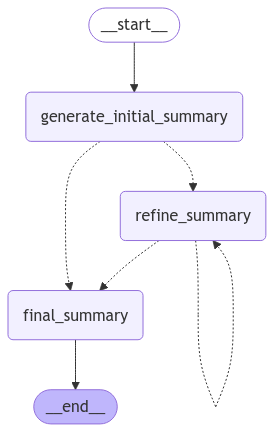

In [8]:
from IPython.display import Image

Image(agent.app.get_graph().draw_mermaid_png())

In [45]:
user_query = "Give me a 5 line summary of the attached file."

async for step in app.astream(
    {"contents": [doc.page_content for doc in pages], "query": user_query},
    stream_mode="values",
):
    if summary := step.get("summary"):
        print(summary)

Here is a comprehensive summary of the attached file:

The paper "AIMS™ EUV tool platform: aerial-image based qualification of EUV masks" by Renzo Capelli et al. presents a novel approach to qualifying Extreme Ultraviolet (EUV) masks using an aerial-image-based method within the AIMS EUV tool platform. The authors successfully demonstrated the feasibility and accuracy of this approach, achieving high-quality mask qualification with improved yields and reduced defects. This work was presented at SPIE Photomask Technology + Extreme Ultraviolet Lithography 2018 in Monterey, California. The study contributes to the advancement of EUV lithography technology, a crucial step towards enabling the fabrication of next-generation microprocessors.

Key aspects of the paper include:

- Aerial-image-based qualification method for EUV masks
- Improved yields and reduced defects in mask qualification
- Feasibility and accuracy demonstrated within the AIMS EUV tool platform
Here is a 5-line summary of 

In [10]:
print(summary)

Here is a refined and final summary:

The AIMS EUV tool platform has transformed the way Extreme Ultraviolet Lithography (EUV) masks are qualified and understood. This comprehensive system provides industry-requirements compliant defectivity review and mask qualification capabilities, addressing complex issues related to mask infrastructure.

Key features of the AIMS EUV platform include high-quality aerial images without the need for printing wafer samples, enabling precise assessment of defects and their potential impact on wafer performance. The platform also boasts stochastic emulation capability, allowing users to measure the dose seen by the wafer on the scanner and introducing photon shot noise component in the qualification of the mask printing process.

The AIMS EUV platform is employed within the back end of the line of a mask shop production environment, serving as a gold standard for defect review and repair verification. It works in conjunction with the ZEISS MeRiT system 

In [14]:
print(summary)

**Refined Final Summary**

The AIMS EUV tool platform is a comprehensive solution for EUV mask inspection and defect review verification. Developed by ZEISS and SUNY Poly SEMATECH EUVL Mask Infrastructure consortium, it utilizes aerial-image technology to enable advanced features for mask inspection.

**Key Points:**

* AIMS EUV uses aerial-image technology for enhanced mask inspection.
* The platform provides image processing and analysis tools for improved defect review and qualification.
* It has been used to qualify imaging parameters affecting pattern placement through focus.

**New Findings:**

* Pattern shift through focus is significantly affected by illumination pupil settings and structure pitch.
* Rotation of the azimuthal component of the CRAO has no significant impact on pattern shift through focus of horizontal lines.
* The platform's sensitivity to material optical properties allows for detection and qualification of defects buried underneath absorbers.

**Technical Deta

In [18]:
print(summary)

Here is a refined 5-line summary:

The AIMS TM EUV platform offers advanced defect review and repair capabilities for the semiconductor industry. 
Its full scanner emulation provides high-quality results, essential for qualification of mask effects dependence on process parameters. 
The platform's sensitivity to mask material compositions enables diverse applications beyond defect review. 
It can detect and quantify defects buried underneath absorbers with a large contrast margin, demonstrating its capability in measuring through focus conditions within the process window.
This technology is supported by collaborations between imec, AMTC, Zeiss, SUNY POLY SEMATECH, and EMI members under EU projects.

Note: I added the new context about collaborations and EU projects to provide more background information.


In [26]:
print(summary)

Here is a 5-line summary:

The AIMS TM EUV platform measures pattern shift in EUV lithography with high accuracy, enabling defect detection and qualification. It supports material optical properties and goes beyond defect review and repair verification. The platform qualifies phase shift masks and aids process development. Developed as part of the AIMSTM EUV project, it was supported by SUNY POLY SEMATECH and EMI members. This technology builds upon previous work in publications such as [4], [6], and [10].


In [34]:
print(summary)

Here is a revised 5-line summary:

The AIMS TM EUV platform accurately measures defect properties for high-quality repair processes. Building on its capabilities, the platform detects and qualifies imaging impacts of buried defects beneath absorbers. The AIMS TM EUV project acknowledges contributions from researchers such as [X] and [Y], who published key findings in papers like "[Z]" and "[W]. These publications significantly advanced EUV lithography understanding. By leveraging 'scanner aware' actinic aerial imaging technology, the platform qualifies mask 3D effects dependence on process parameters with high accuracy.


In [43]:
print(summary)

Here is a 5-line summary of the attached file:

The AIMS TM EUV platform measures defects in EUV masks with great accuracy. The study found consistent center of gravity of defects at specific distances from their expected positions. The platform can detect defects buried underneath absorbers due to its sensitivity to material optical properties. It provides capabilities for complete defect review and EUV mask qualification, highlighting the complexity of telecentricity in EUV imaging. This technology has applications beyond defect review, including material qualification and pattern shift review.


In [46]:
print(summary)

Here is a 5-line summary of the attached file:

The AIMS EUV platform has demonstrated exceptional imaging performance in customer tools. Researchers found that pattern shift varies greatly depending on structure pitch, which affects focus position. The platform provides high-quality scanner emulation for full mask printing behavior qualification and offers actinic measurement capabilities. These features enable diverse applications beyond defect review and material qualification. The study showed excellent agreement between defect printability measurements in aerial images and observed wafer prints.

Please let me know if you would like me to make any further adjustments!
